# Digital Equity and Inclusion - Machine Learning to close the digital divide #
                  
   **Jason Kronemeyer (jfkrone@umich.edu), Liang Yao(yaoliang@umich.edu), Samuel Buxton (sambux@umich.edu)**



## The Goal: ##

**This project aims to measure and forecast progress on digital equity in Michigan. Digital equity refers to the equal distribution of digital resources and opportunities, including access to high-speed internet, digital devices, and digital literacy training. One challenge in this project is the availability and quality of data on digital equity in Michigan. Another challenge is the complexity of the problem, as there are many socioeconomic factors that contribute to the digital divide.**
 
The project will consist of two parts:

**Part A(Supervised learning):** Our goal is to forecast internet access and digital equity levels in areas of
Michigan. Since we are using both categorical and quantitative variables to predict our quantitative equity metric, we plan to compare the efficacy of a linear regression approach with dummy variables against a random forest regressor.
 
**Part Part B(Unsupervised learning):** Our goal is know about pattern or structure of the dataset, and identify the principal components and features in the data that can help us to understand and predict progress on digital equity in Michigan..

**Install libraries**

In [78]:
!pip install geopandas

**Import libraries**

In [79]:
# import packages we need

from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from shapely.geometry import Point
# from adjustText import adjust_text

**Remove warnings**

In [80]:
import warnings
warnings.filterwarnings('ignore')

In [81]:
# Display settings
%config InlineBackend.figure_format = "retina" # make figures look better 
np.set_printoptions(precision=3)

# Part B (Unsupervised learning): #



## STEP 1: Data Preprocessing<a id='章节1'></a>

In [82]:
gdf = None
gdf = gpd.read_file("./assets/sections_with_network (1).shp")
gdf.columns

Index(['OBJECTID_1', 'OBJECTID_l', 'michigan_M', 'PERIMETER', 'TOWN', 'RANGE',
       'SECTION', 'SEC', 'TWNRNG', 'TWNRNGSEC', 'CLAIM', 'GOVLOT', 'OTHER',
       'COUNTY', 'Shape_STAr', 'Shape_STLe', 'Shape_ST_1', 'Shape_ST_2',
       'Shape_ST_3', 'Shape_ST_4', 'ShapeSTAre', 'ShapeSTLen', 'index_righ',
       'quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'index_ri_1', 'OBJECTID_r', 'FIPSCODE', 'FIPSNUM', 'NAME', 'LABEL',
       'TYPE', 'SQKM', 'SQMILES', 'ACRES', 'VER', 'LAYOUT', 'PENINSULA',
       'ShapeSTA_1', 'ShapeSTL_1', 'avg_d_mbps', 'avg_u_mbps', 'year_qtr',
       'geometry'],
      dtype='object')

In [83]:
print(gdf['year_qtr'].value_counts())
nan_count = gdf['year_qtr'].isna().sum()
print("\033[94m"+"\033[1m"+"Number of NaN values in 'year_qtr' column:", nan_count)
#You would notice that some year and quarter's data is missing. The time stamp is not continuous.

2022q3    1382
2020q3    1159
2023q2    1089
2019q4    1036
2020q2    1035
2019q3     963
2022q4     931
2020q1     877
2020q4     788
2023q1     726
2019q2     703
2019q1     611
Name: year_qtr, dtype: int64
Number of NaN values in 'year_qtr' column: 6995


In [84]:
value_counts = gdf['TWNRNGSEC'].value_counts()
print(value_counts)
#You would notice that some town sections were tested only once.
print("\033[94m"+"\033[1m"+"Total number of unique town sections:", len(value_counts))

40N03W      381
47N01E07    303
47N01E06    212
47N01E08    210
47N01E05    202
           ... 
43N02E06      1
50N09W23      1
47N12W16      1
41N04E05      1
45N12W14      1
Name: TWNRNGSEC, Length: 1174, dtype: int64
Total number of unique town sections: 1174


In [85]:
only_once = value_counts[value_counts == 1]
print("\033[94m"+"\033[1m"+"The number of town sections which only test once time:", len(only_once))
percentage = round((len(only_once) / len(value_counts)) * 100, 2)
print("\033[94m"+"\033[1m"+"the ratio of only test once time:", f"{percentage}%")
# You need to notice the hidden imbalance and unreliable risks in this data, 
# where the number of tests were so different across each town section, and even up to 27% of town sections were tested only once.

The number of town sections which only test once time: 253
the ratio of only test once time: 21.55%


In [86]:
gdf.sample(1)

,OBJECTID_1,OBJECTID_l,michigan_M,PERIMETER,TOWN,RANGE,SECTION,SEC,TWNRNG,TWNRNGSEC,...,ACRES,VER,LAYOUT,PENINSULA,ShapeSTA_1,ShapeSTL_1,avg_d_mbps,avg_u_mbps,year_qtr,geometry
3571,7134,7134,0,6454.45712,47N,01E,30,30,47N01E,47N01E30,...,43399.416538,20,landscape,upper,1.756331e+08,99898.197083,185.267,23.06,2019q4,"POLYGON ((-84.34322 46.44855, -84.34304 46.434..."


## STEP 2: PCA analysis

In [87]:
selected_df=gdf[['TWNRNGSEC','avg_d_mbps','avg_u_mbps','avg_lat_ms','geometry']]
grouped_df = selected_df.groupby(['TWNRNGSEC']).mean()
print(grouped_df)
# In order to get one set of value of network metrics for each Town section.

           avg_d_mbps  avg_u_mbps  avg_lat_ms
TWNRNGSEC                                    
40N02W18    19.708444    1.557111   60.222222
40N02W19    31.219852    4.015037   60.555556
40N03W      49.258286   12.611013   44.359580
40N03W02    51.946333    8.033333   68.333333
40N03W06    88.839830   10.249955   26.011364
...               ...         ...         ...
50N09W25    36.858000    2.228000  643.000000
50N09W26    36.858000    2.228000  643.000000
50N12W32     7.042000    1.058000   22.000000
51N05W31   204.484286   19.825429   54.142857
51N06W36   140.191000   13.924000   57.000000

[1174 rows x 3 columns]


In [88]:
from sklearn.preprocessing import StandardScaler

def get_normalize():
    np.random.seed(42)
    result = None
    result = StandardScaler().fit_transform(grouped_df)
    return result

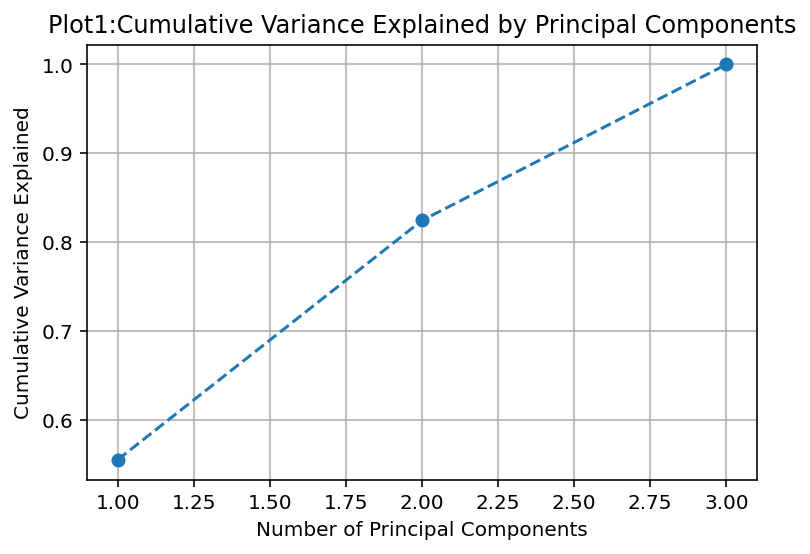

In [89]:
#Creat a cumulative variance explained plot,
#it typically used to help determine how many principal components (dimensions) to retain in Principal Component Analysis (PCA).
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=None
pca = PCA(random_state=42).fit(get_normalize())  
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Plot1:Cumulative Variance Explained by Principal Components')
plt.grid()
plt.show()

In [90]:
cumulative_variance_ratio = explained_variance_ratio.cumsum()
desired_variance_ratio = 0.95  #  set 95% as cumulative variance explained threshold
components_needed = np.where(cumulative_variance_ratio >= desired_variance_ratio)[0][0] + 1
components_needed
print("\033[94m"+"\033[1m"+"The components we need in PCA:", components_needed)

The components we need in PCA: 3


In [91]:
# We input n_components = 3, don't forget set random_state = 42 to ensure reproducibility
from sklearn.decomposition import PCA
def get_pca():
    result = None
    pca = PCA(n_components = 3, random_state = 42)
    result = pca.fit(get_normalize())# haven't transformed,just fit
    return result

## STEP 3: LOF to detect Outliers

In [92]:
#Local Outlier Factor (LOF) algorithm to detect outliers in a dataset and find the best LOF parameter combination. 

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
np.random.seed(42)
normalized_data = get_normalize()
pca_transformed = get_pca().transform(normalized_data)

n_neighbors_values = [10,20,30,40,50,60,70,80,90,100]
contamination_values = [0.01, 0.05, 0.1, 0.2]

best_silhouette_score = -1
best_params = {}

for n_neighbors in n_neighbors_values:
    for contamination in contamination_values:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        y_pred = lof.fit_predict(pca_transformed)  
        silhouette_avg = silhouette_score(pca_transformed, y_pred)

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_params['n_neighbors'] = n_neighbors
            best_params['contamination'] = contamination

print("\033[94m"+"\033[1m"+"Best Parameters:", best_params)
print("\033[94m"+"\033[1m"+"Best Silhouette Score:", best_silhouette_score)

Best Parameters: {'n_neighbors': 40, 'contamination': 0.01}
Best Silhouette Score: 0.8098866225181635


In [93]:
# Detecting Outliers Using LOF
lof = LocalOutlierFactor(n_neighbors=40, contamination=0.01)  # 根据需要调整参数
y_pred = lof.fit_predict(pca_transformed)
y_pred_series = pd.Series(y_pred)
y_pred_series.value_counts()
print("\033[94m"+"\033[1m"+"Without Outliers number is:",y_pred_series.value_counts()[1],"(total is 1174)")
print("\033[94m"+"\033[1m"+"Outliers number is:",y_pred_series.value_counts()[-1],"(total is 1174)")

Without Outliers number is: 1162 (total is 1174)
Outliers number is: 12 (total is 1174)


## STEP 4: Remove Outliers from Original Dataset

In [94]:
#Removing Rows of Outlier Town Sections from the Original Data
grouped_df['y_pred'] = y_pred_series.values
no_outliers_grouped_df = grouped_df[grouped_df['y_pred']==1]
no_outlier_TWNRNGSEC = no_outliers_grouped_df.index
outlier_TWNRNGSEC = grouped_df[grouped_df['y_pred']==-1].index
print("\033[94m"+"\033[1m"+"Outliers Town Section ID are:",outlier_TWNRNGSEC )
selected_df_new =selected_df[selected_df['TWNRNGSEC'].isin(no_outlier_TWNRNGSEC)]
print()
print("\033[94m"+"\033[1m"+"New mean dataset length is:",len(selected_df_new),"and Original mean dataset length is:",len(selected_df)) 
no_outliers_grouped_df = no_outliers_grouped_df.drop(columns=['y_pred'])
no_outliers_grouped_df

Outliers Town Section ID are: Index(['42N04E29', '42N04E32', '42N04E33', '42N06E21', '43N01E03', '43N10W05',
       '43N12W07', '44N01E34', '45N01W15', '46N02W10', '46N10W34', '48N01E36'],
      dtype='object', name='TWNRNGSEC')

New mean dataset length is: 16380 and Original mean dataset length is: 18295


,avg_d_mbps,avg_u_mbps,avg_lat_ms
TWNRNGSEC,,,
40N02W18,19.708444,1.557111,60.222222
40N02W19,31.219852,4.015037,60.555556
40N03W,49.258286,12.611013,44.359580
40N03W02,51.946333,8.033333,68.333333
40N03W06,88.839830,10.249955,26.011364
...,...,...,...
50N09W25,36.858000,2.228000,643.000000
50N09W26,36.858000,2.228000,643.000000
50N12W32,7.042000,1.058000,22.000000


## STEP 5: Derive New PCA model from new dataset

In [95]:
# Based on the new data with outliers removed, derive a new PCA model.
def get_new_normalize():
    np.random.seed(42)
    result = None
    result = StandardScaler().fit_transform(no_outliers_grouped_df)
    return result

def get_new_pca():
    np.random.seed(42)
    result = None
    pca = PCA(n_components = 3, random_state = 42)
    result = pca.fit(get_new_normalize())#haven't transform
    return result

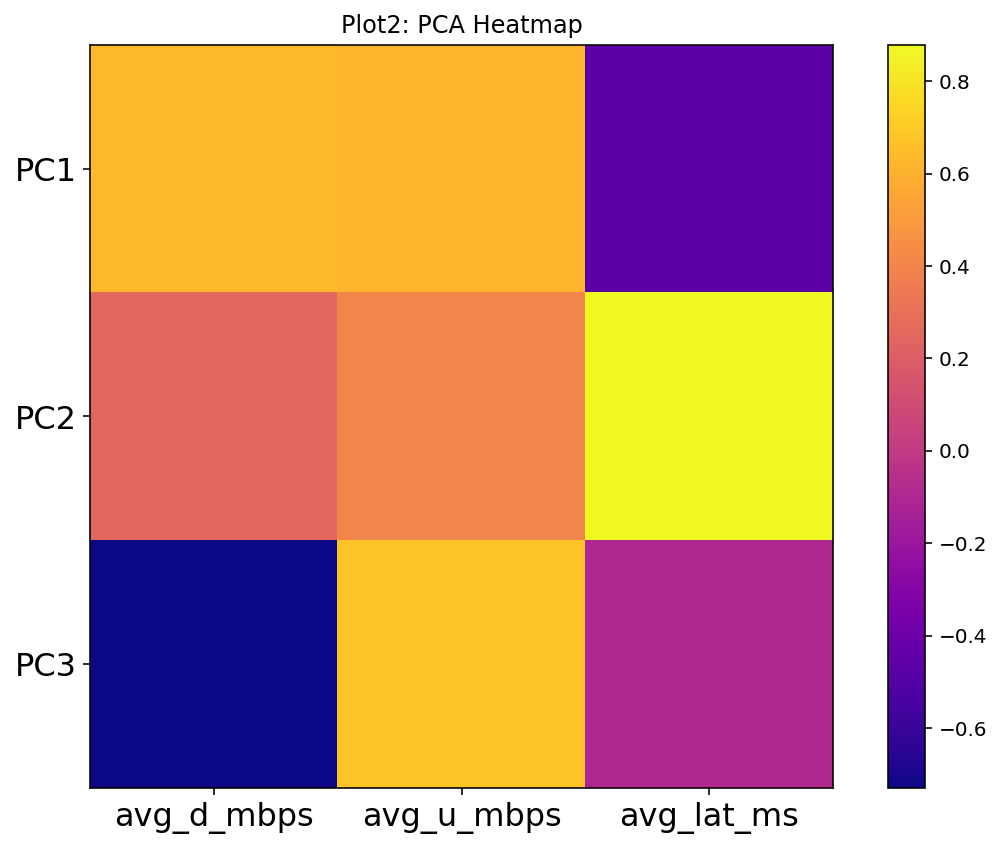

In [96]:
def plot_pca_heatmap():
    pc_names=["PC1","PC2","PC3"]
    fig,ax = plt.subplots(figsize=(8,6))
    pca_components_to_show = get_new_pca().components_[:3, :]
    plt.imshow(pca_components_to_show,cmap = 'plasma')
    plt.xticks(np.arange(0,3,1),['avg_d_mbps','avg_u_mbps','avg_lat_ms'],rotation =0, fontsize=16)
    plt.yticks(np.arange(0,3,1),pc_names,fontsize=16)
    plt.title('Plot2: PCA Heatmap')
    plt.colorbar()
    plt.tight_layout()
    return 
plot_pca_heatmap()

In [97]:
pca = get_new_pca()
# Get the weights for the first two principal components
weights = pca.components_[:3, :]
# Iterate through the principal components and features
for i, pc in enumerate(weights):
    for j, feature in enumerate(['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms']):
        # Format the weight to two decimal places
        weight_formatted = f"{pc[j]:.2f}"
        print("\033[94m"+"\033[1m"+f"PC{i + 1} weight for {feature}: {weight_formatted}")

# Get the variance (eigenvalues) of PCA
eigenvalues = pca.explained_variance_

# Calculate the variance of Principal Component 1 (PC1)
variance_pc1 = eigenvalues[0]

# Calculate the variance of Principal Component 2 (PC2)
variance_pc2 = eigenvalues[1]

# Calculate the variance of Principal Component 3 (PC3)
variance_pc3 = eigenvalues[2]

# Calculate the variance contribution ratio
total_variance = sum(eigenvalues)
variance_ratio_pc1 = variance_pc1 / total_variance
variance_ratio_pc2 = variance_pc2 / total_variance
variance_ratio_pc3 = variance_pc3 / total_variance

# Format the values with two decimal places
variance_pc1_formatted = "{:.2f}".format(variance_pc1)
variance_pc2_formatted = "{:.2f}".format(variance_pc2)
variance_pc3_formatted = "{:.2f}".format(variance_pc3)
variance_ratio_pc1_formatted = "{:.2f}".format(variance_ratio_pc1)
variance_ratio_pc2_formatted = "{:.2f}".format(variance_ratio_pc2)
variance_ratio_pc3_formatted = "{:.2f}".format(variance_ratio_pc3)


print("Variance of PC1:", variance_pc1_formatted)
print("Variance of PC2:", variance_pc2_formatted)
print("Variance of PC3:", variance_pc3_formatted)
print("Variance Ratio of PC1:", variance_ratio_pc1_formatted)
print("Variance Ratio of PC2:", variance_ratio_pc2_formatted)
print("Variance Ratio of PC3:", variance_ratio_pc3_formatted)


PC1 weight for avg_d_mbps: 0.64
PC1 weight for avg_u_mbps: 0.61
PC1 weight for avg_lat_ms: -0.47
PC2 weight for avg_d_mbps: 0.26
PC2 weight for avg_u_mbps: 0.41
PC2 weight for avg_lat_ms: 0.88
PC3 weight for avg_d_mbps: -0.73
PC3 weight for avg_u_mbps: 0.68
PC3 weight for avg_lat_ms: -0.10
Variance of PC1: 1.86
Variance of PC2: 0.76
Variance of PC3: 0.38
Variance Ratio of PC1: 0.62
Variance Ratio of PC2: 0.25
Variance Ratio of PC3: 0.13


**FINDING 1:**

- PC1: 0.64 * avg_d_mbps + 0.61 * avg_u_mbps - 0.47 * avg_lat_ms
- PC2: 0.26 * avg_d_mbps + 0.41 * avg_u_mbps + 0.88 * avg_lat_ms
- PC3: -0.73 * avg_d_mbps + 0.68 * avg_u_mbps - 0.10 * avg_lat_ms


PC1 has high positive weights for 'avg_d_mbps' (0.64) and 'avg_u_mbps' (0.61), suggesting a strong association with network speed. However, it has a negative weight for 'avg_lat_ms' (-0.47), indicating an inverse relationship in network latency.

PC2 has positive weights for 'avg_u_mbps' (0.41) and 'avg_lat_ms' (0.88), showing a connection between upload speed and latency.

PC3 has negative correlation with 'avg_d_mbps'(-0.73), and shows a positive correlation with 'avg_u_mbps'(0.67), indicating that an increase in upload speed leads to a higher PC3 value.

Variance of PC1 is 1.86, and it contributes about 62% (Variance Ratio of PC1) of the total data variance.

Variance of PC2 is 0.76, and it contributes approximately 25% (Variance Ratio of PC2) of the total data variance.

Variance of PC23 is 0.38, and it contributes approximately 13% (Variance Ratio of PC3) of the total data variance.


**In summary**

1）PC1 is associated with network speed (download and upload) but has an inverse relationship with latency.PC2 is linked to upload speed and latency.PC3 has inverse relationship with download speed and linked to upload speed.

2）PC1 explains a larger portion of the data's variance（62%）, indicating its significance in understanding network performance patterns. PC2 contributes at some extent（25%）, and PC3 also contributes 13%, suggesting their role in complementing the understanding of the dataset's variability.

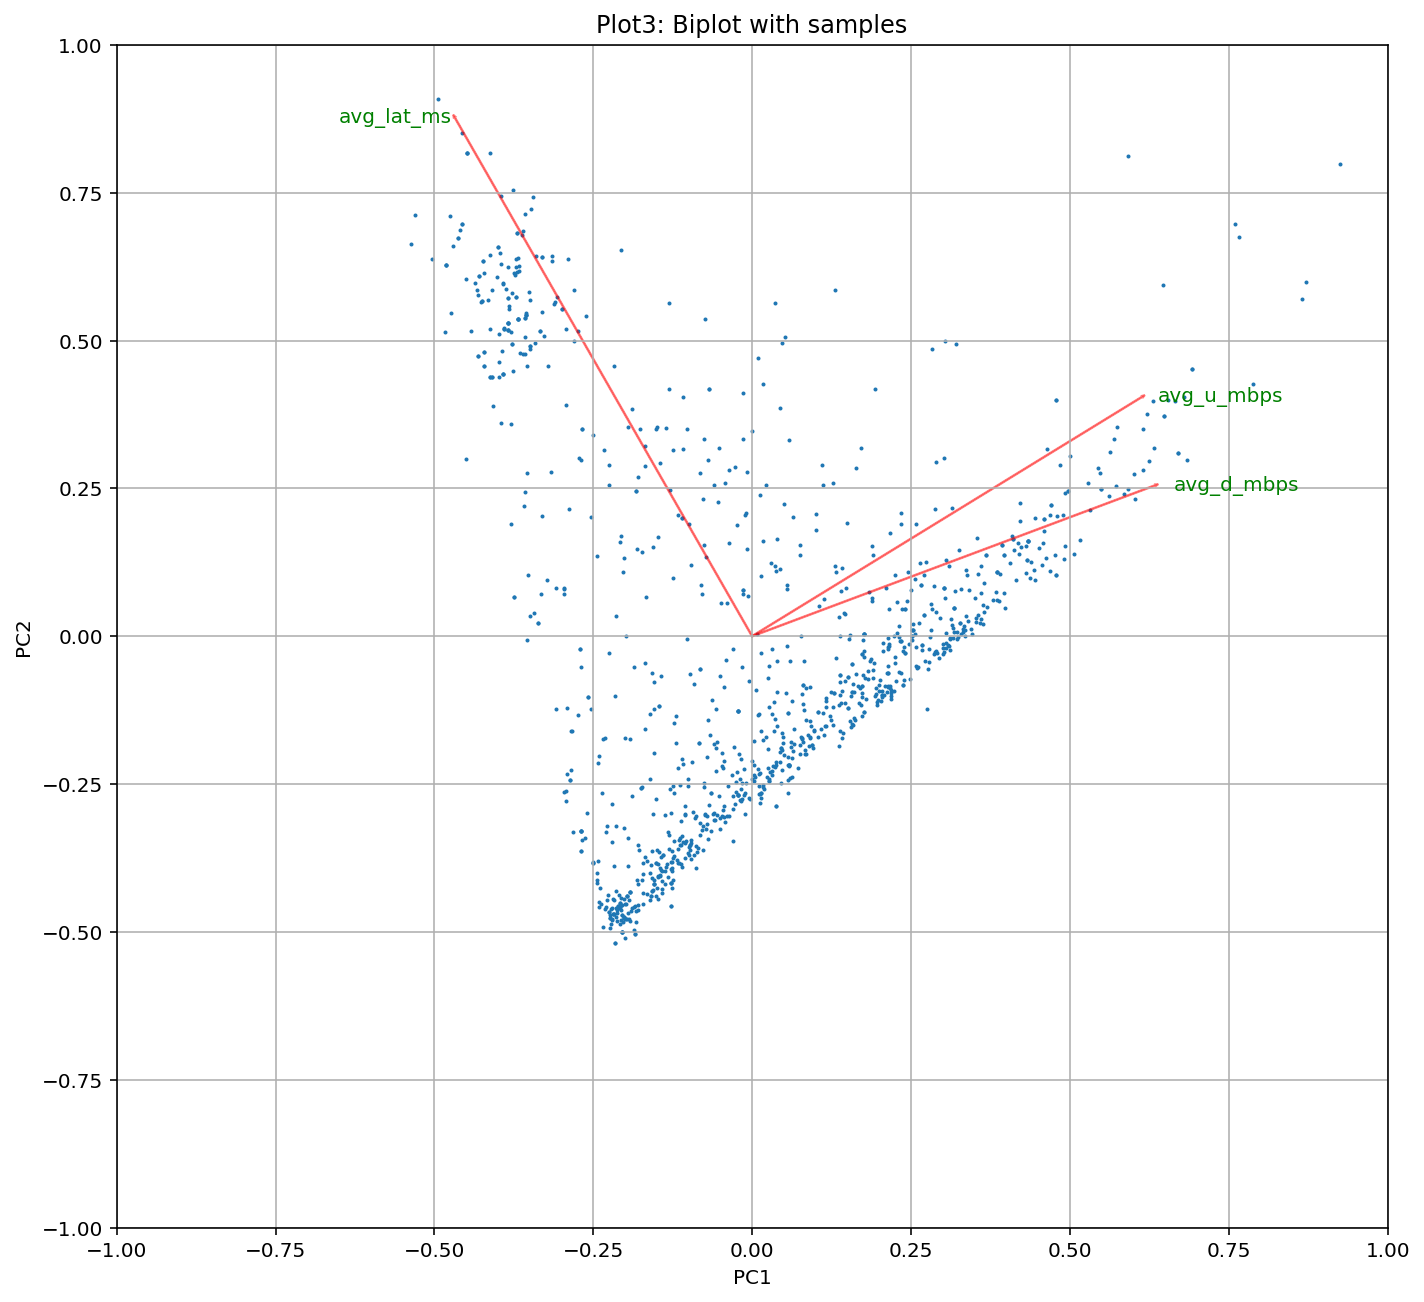

In [98]:
#Biplots are helpful for exploring and understanding complex datasets, identifying relationships between variables and observations samples.
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    """Routine to generate a high-quality biplot"""

    pca1 = pcax - 1
    pca2 = pcay - 1
    xs = score[:, pca1]
    ys = score[:, pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0 / (xs.max() - xs.min())
    scaley = 2.0 / (ys.max() - ys.min())

    text_scale_factor = 1.2

    plt.figure(figsize=(10, 9))
    plt.scatter(xs * scalex, ys * scaley, s=1)


    for i in range(n):
        plt.arrow(0, 0, coeff[i, pca1], coeff[i, pca2], color="r", alpha=0.5)
        if labels is None:
            plt.text(
                coeff[i, pca1] * text_scale_factor,
                coeff[i, pca2] * text_scale_factor,
                "Var" + str(i + 1),
                color="g",
                ha="center",
                va="center",
            )
        else:
            plt.text(
                coeff[i, pca1] * text_scale_factor,
                coeff[i, pca2],
                labels[i],
                color="g",
                ha="center",
                va="center",
            )
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    plt.tight_layout()

    return


def make_biplot():
    
    normalized_new_data = get_new_normalize()
    pca_non_transformed_new = get_new_pca()
    pca_transformed_new = pca_non_transformed_new.transform(normalized_new_data)

    biplot(
       pca_transformed_new, np.transpose(get_new_pca().components_[0:2, :]), 3, 1, 2, labels=['avg_d_mbps','avg_u_mbps','avg_lat_ms']
    )
    plt.title('Plot3: Biplot with samples')
    return

make_biplot()

## STEP 6: Use KMeans to get Clustering

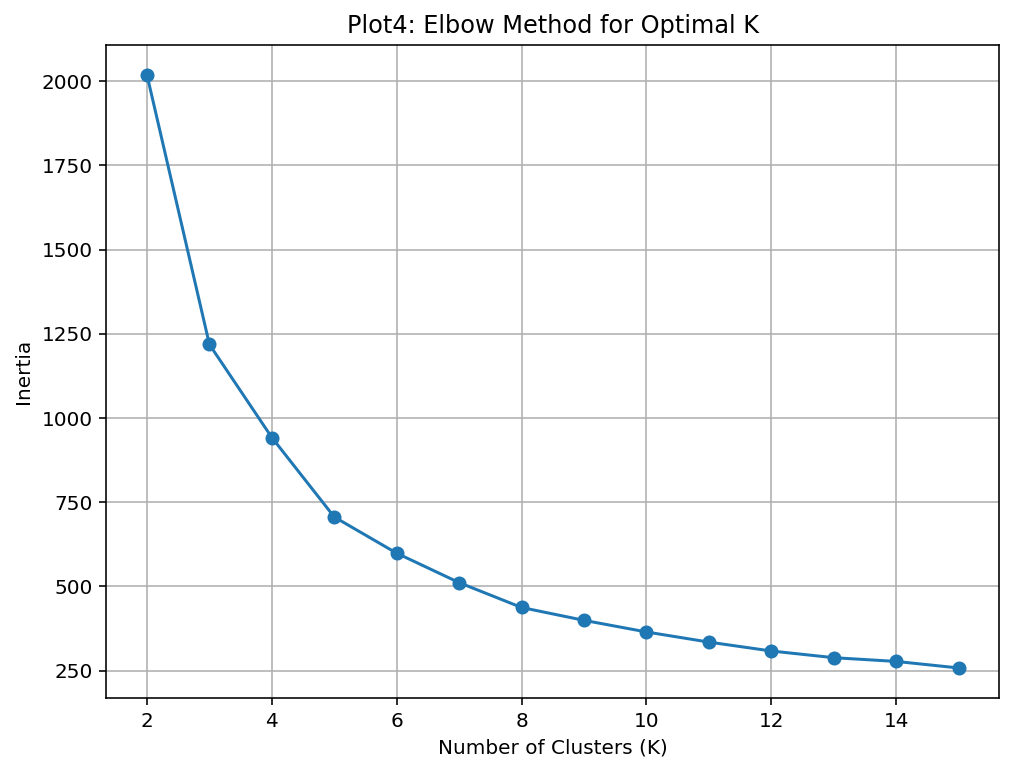

In [99]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
np.random.seed(42)
normalized_new_data = get_new_normalize()
pca_transformed_new = get_new_pca().transform(normalized_new_data)

# define the range of K
k_values = range(2, 16)
inertias = []


for k in k_values:
    kmeans = None
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_transformed_new)
    inertias.append(kmeans.inertia_)

# 绘制肘部法则图表
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Plot4: Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [100]:

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

normalized_new_data = get_new_normalize()
pca_transformed_new =get_new_pca().transform(normalized_new_data)

# 定义一组可能的K值
k_values = range(2, 11)
best_calinski_harabasz = -1
best_davies_bouldin = float("inf")
best_k = 0


for k in k_values:
    kmeans=None
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans = kmeans.fit(pca_transformed_new)
    labels = kmeans.labels_

    calinski_harabasz = calinski_harabasz_score(pca_transformed_new, labels)
    davies_bouldin = davies_bouldin_score(pca_transformed_new, labels)
    

    if calinski_harabasz > best_calinski_harabasz and davies_bouldin < best_davies_bouldin:
        best_calinski_harabasz = calinski_harabasz
        best_davies_bouldin = davies_bouldin
        best_k = k

print("\033[94m"+"\033[1m"+"Best K value(K-means):", best_k)
print("\033[94m"+"\033[1m"+"Best Calinski-Harabasz score(K-means):", best_calinski_harabasz)
print("\033[94m"+"\033[1m"+"Best Davies-Bouldin score(K-means):", best_davies_bouldin)

Best K value(K-means): 5
Best Calinski-Harabasz score(K-means): 1138.5396573608805
Best Davies-Bouldin score(K-means): 0.7306407004457093


In [101]:
def get_kmeans(best_k = 5):
    result = None
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    result = kmeans.fit(pca_transformed_new)  
    return result  


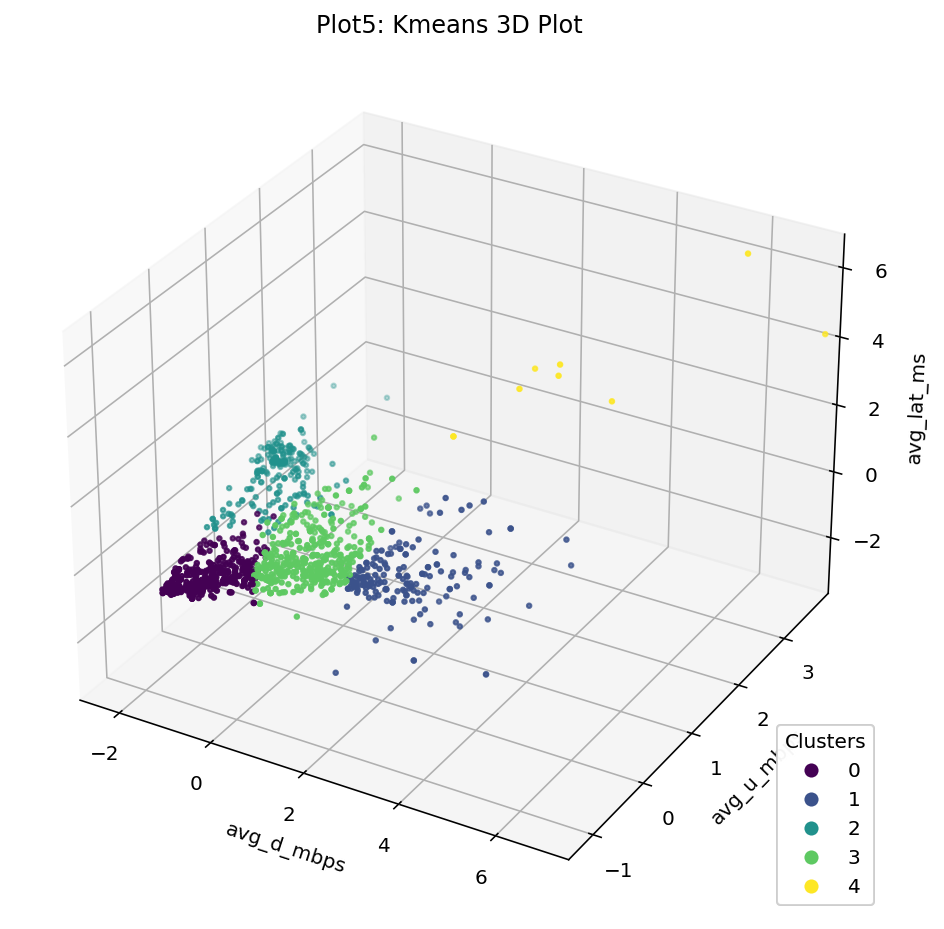

In [102]:
from mpl_toolkits.mplot3d import Axes3D  

def kmeans_3d_plot():
    kmeans = get_kmeans(best_k = 5)
    cluster_labels = list(kmeans.labels_)
    X = list(pca_transformed_new[:,0])
    Y = list(pca_transformed_new[:,1])
    Z = list(pca_transformed_new[:,2])
 
    fig = plt.figure(figsize=(12, 8)) 
    ax = fig.add_subplot(projection='3d') 

    sc = ax.scatter(X, Y, Z, c=cluster_labels, cmap='viridis', marker='o',s=5)
    ax.set_xlabel('avg_d_mbps')
    ax.set_ylabel('avg_u_mbps')
    ax.set_zlabel('avg_lat_ms')
    ax.set_title('Plot5: Kmeans 3D Plot')
    
    legend = ax.legend(*sc.legend_elements(), loc="lower right", title="Clusters")
    ax.add_artist(legend)
    

    ax.set_xlim([min(X), max(X)])
    ax.set_ylim([min(Y), max(Y)])
    ax.set_zlim([min(Z), max(Z)])
 
    plt.show()

    return 
kmeans_3d_plot()

## STEP 7: Use KMedoids to get Clustering

In [103]:
!pip install scikit-learn-extra

In [104]:
from sklearn_extra.cluster import KMedoids

normalized_new_data = get_new_normalize()
pca_non_transformed_new = get_new_pca()
pca_transformed_new = pca_non_transformed_new.transform(normalized_new_data)

# Define a range of possible K values
k_values = range(2, 11)

best_calinski_harabasz = -1
best_davies_bouldin = float("inf")
best_k = 0

# Calculate Calinski-Harabasz and Davies-Bouldin scores for each K value
for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42, metric='manhattan')
    kmedoids.fit(pca_transformed_new)
    labels = kmedoids.labels_

    calinski_harabasz = calinski_harabasz_score(pca_transformed_new, labels)
    davies_bouldin = davies_bouldin_score(pca_transformed_new, labels)
    
    # Select the best K value
    if calinski_harabasz > best_calinski_harabasz and davies_bouldin < best_davies_bouldin:
        best_calinski_harabasz = calinski_harabasz
        best_davies_bouldin = davies_bouldin
        best_k = k

print("\033[94m"+"\033[1m"+"Best K value (KMedoids):", best_k)
print("\033[94m"+"\033[1m"+"Best Calinski-Harabasz score (KMedoids):", best_calinski_harabasz)
print("\033[94m"+"\033[1m"+"Best Davies-Bouldin score (KMedoids):", best_davies_bouldin)

Best K value (KMedoids): 3
Best Calinski-Harabasz score (KMedoids): 1045.8405297551813
Best Davies-Bouldin score (KMedoids): 0.727286927815896


In [105]:
def get_kmedoids(best_k = 3):
    result = None
    kmedoids = KMedoids(n_clusters=best_k, random_state=42)
    result = kmedoids.fit(pca_transformed_new)  
    return result  

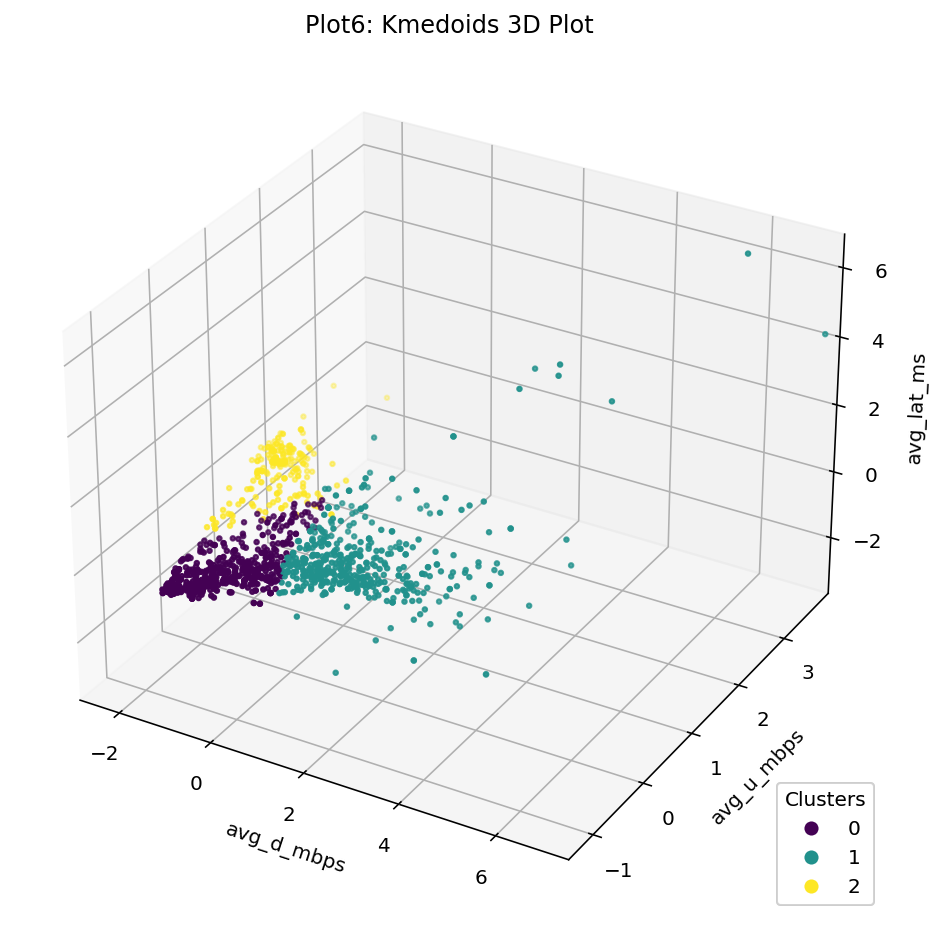

In [106]:
from mpl_toolkits.mplot3d import Axes3D  

def kmedoids_3d_plot():
    kmedoids = get_kmedoids(best_k = 3)
    cluster_labels = list(kmedoids.labels_)
    X = list(pca_transformed_new[:,0])
    Y = list(pca_transformed_new[:,1])
    Z = list(pca_transformed_new[:,2])

    fig = plt.figure(figsize=(12, 8))  
    ax = fig.add_subplot(projection='3d')  
    
    sc = ax.scatter(X, Y, Z, c=cluster_labels, cmap='viridis', marker='o',s=5)
    ax.set_xlabel('avg_d_mbps')
    ax.set_ylabel('avg_u_mbps')
    ax.set_zlabel('avg_lat_ms')
    ax.set_title('Plot6: Kmedoids 3D Plot')
    
    legend = ax.legend(*sc.legend_elements(), loc="lower right", title="Clusters")
    ax.add_artist(legend)
    

    ax.set_xlim([min(X), max(X)])
    ax.set_ylim([min(Y), max(Y)])
    ax.set_zlim([min(Z), max(Z)])
    
    plt.show()

    return 

kmedoids_3d_plot()

## STEP 8: Extract the representative data points from KMeans

In [107]:
from sklearn.metrics import pairwise_distances_argmin_min
# Create a KMeans model and fit the data
np.random.seed(42)
kmeans = get_kmeans(best_k=5)

# Get the centroids of each cluster
cluster_centers = kmeans.cluster_centers_

# Find the indices of the closest data points in each cluster
closest_points_indices = pairwise_distances_argmin_min(cluster_centers, pca_transformed_new)

# Assign labels or names to the clusters
cluster_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
# Column names needed
column_names = ['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms']

# Get the number of data points in each cluster
cluster_assignments = kmeans.labels_
cluster_sizes = np.bincount(cluster_assignments)

# Display the typical data points, labels, and data point counts for each cluster
for i, cluster_center in enumerate(cluster_centers):

    cluster_name = cluster_labels[i]
    closest_data_point_idx = int(closest_points_indices[0][i])  # Ensure it's an integer index

    closest_data_point = no_outliers_grouped_df.iloc[closest_data_point_idx]  # Use .iloc to index DataFrame

    cluster_size = cluster_sizes[i]  # Get the number of data points in the cluster

    print(f"Cluster: {cluster_name}")
    for col, value in zip(column_names, closest_data_point):
        value_formatted = f"{value:.2f}"  # Format the value to two decimal places
        print(f"{col}: {value_formatted}")
    print(f"Town sections in Cluster: {cluster_size}")

Cluster: Cluster 1
avg_d_mbps: 21.12
avg_u_mbps: 3.28
avg_lat_ms: 94.67
Town sections in Cluster: 376
Cluster: Cluster 2
avg_d_mbps: 145.59
avg_u_mbps: 14.34
avg_lat_ms: 56.80
Town sections in Cluster: 179
Cluster: Cluster 3
avg_d_mbps: 19.21
avg_u_mbps: 4.15
avg_lat_ms: 631.00
Town sections in Cluster: 214
Cluster: Cluster 4
avg_d_mbps: 68.56
avg_u_mbps: 10.61
avg_lat_ms: 88.43
Town sections in Cluster: 384
Cluster: Cluster 5
avg_d_mbps: 44.96
avg_u_mbps: 44.34
avg_lat_ms: 35.75
Town sections in Cluster: 9


## STEP 9: Extract the representative data points from KMedoids

In [108]:
from sklearn.metrics import pairwise_distances_argmin_min

# Create a KMeans model and fit the data
kmedoids = get_kmedoids(best_k=3)

# Get the centroids of each cluster
cluster_centers = kmedoids.cluster_centers_

# Find the indices of the closest data points in each cluster
closest_points_indices = pairwise_distances_argmin_min(cluster_centers, pca_transformed_new)

# Assign labels or names to the clusters
cluster_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# Column names needed
column_names = ['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms']

# Get the number of data points in each cluster
cluster_assignments = kmedoids.labels_
cluster_sizes = np.bincount(cluster_assignments)

# Display the typical data points, labels, and data point counts for each cluster
for i, cluster_center in enumerate(cluster_centers):

    cluster_name = cluster_labels[i]
    closest_data_point_idx = int(closest_points_indices[0][i])  # Ensure it's an integer index

    closest_data_point = no_outliers_grouped_df.iloc[closest_data_point_idx]  # Use .iloc to index DataFrame

    cluster_size = cluster_sizes[i]  # Get the number of data points in the cluster

    print(f"Cluster: {cluster_name}")
    for col, value in zip(column_names, closest_data_point):
        value_formatted = f"{value:.2f}"  # Format the value to two decimal places
        print(f"{col}: {value_formatted}")
    print(f"Town sections in Cluster: {cluster_size}")


Cluster: Cluster 1
avg_d_mbps: 26.08
avg_u_mbps: 4.03
avg_lat_ms: 85.96
Town sections in Cluster: 507
Cluster: Cluster 2
avg_d_mbps: 98.82
avg_u_mbps: 12.10
avg_lat_ms: 57.20
Town sections in Cluster: 447
Cluster: Cluster 3
avg_d_mbps: 17.56
avg_u_mbps: 3.90
avg_lat_ms: 637.00
Town sections in Cluster: 208


## STEP 10: Select an appropriate number of clusters 

**FINDING 2:**

- From KMeans:

Best K value(K-means): 5

Best Calinski-Harabasz score(K-means): 1138.5396573608805

Best Davies-Bouldin score(K-means): 0.7306407004457093
 

- From KMedoids

Best K value (KMedoids): 3

Best Calinski-Harabasz score (KMedoids): 1045.8405297551813

Best Davies-Bouldin score (KMedoids): 0.727286927815896

- The scores from KMeans are similar with those from KMedoids, but the difference is not very significant.
- Considering clustering metrics, it's important to take into account the balance of clusters.
- When you look into KMeans clustering, the Cluster: the number of Cluster 5 town sections is only 9.
- In this case, selecting KMedoids clustering 3 instead of KMeans clustering 5 is to ensure relatively balanced clustering and to reduce the impact of imbalanced data on subsequent supervised learning models. 
- Using KMedoids clustering 3 is a reasonable decision that can enhance the stability and performance of the model.


## STEP 11: Assign the labels

In [109]:
# Calculate the mean of columns 'avg_d_mbps', 'avg_u_mbps', and 'avg_lat_ms' in 'no_outliers_df'
avg_d_mbps_mean = round(no_outliers_grouped_df['avg_d_mbps'].mean(), 2)
avg_u_mbps_mean = round(no_outliers_grouped_df['avg_u_mbps'].mean(), 2)
avg_lat_ms_mean = round(no_outliers_grouped_df['avg_lat_ms'].mean(), 2)

# Print the results
print(f'Mean avg_d_mbps: {avg_d_mbps_mean}')
print(f'Mean avg_u_mbps: {avg_u_mbps_mean}')
print(f'Mean avg_lat_ms: {avg_lat_ms_mean}')


Mean avg_d_mbps: 55.81
Mean avg_u_mbps: 7.55
Mean avg_lat_ms: 178.63


**FINDING 3:**

- **Cluster 1: Worse Network -- worse than mean value**

 avg_d_mbps: 26.08 （Mean avg_d_mbps: 55.81）

 avg_u_mbps: 4.03 （Mean avg_u_mbps: 7.55）

 avg_lat_ms: 85.96（Mean avg_lat_ms: 178.63）

 Town sections in Cluster: 507
 

- **Cluster 2: Excellent Network-- much better than mean value**

 avg_d_mbps: 98.82（Mean avg_d_mbps: 55.81）
 
 avg_u_mbps: 12.10（Mean avg_u_mbps: 7.55）
    
 avg_lat_ms: 57.20（Mean avg_lat_ms: 178.63）
    
 Town sections in Cluster: 447


- **Cluster 3: Poor Network --much worse than mean value**

 avg_d_mbps: 17.56 （Mean avg_d_mbps: 55.81）

 avg_u_mbps: 3.90 （Mean avg_u_mbps: 7.55）

 avg_lat_ms: 637.00 （Mean avg_lat_ms: 178.63）
    
 Town sections in Cluster: 208



## STEP 12: Assign the Labels

In [110]:
cluster_labels = kmedoids.labels_
no_outliers_grouped_df
no_outliers_grouped_df_new = no_outliers_grouped_df.copy()
no_outliers_grouped_df_new['cluster_labels']=cluster_labels
no_outliers_grouped_df_new = no_outliers_grouped_df_new.reset_index()

print(no_outliers_grouped_df_new)
print("\033[94m"+"\033[1m"+"Group subset Labels Value Counter", 
      no_outliers_grouped_df_new['cluster_labels'].value_counts())
# To map the label data to each individual town section and prepare it for supervised learning

     TWNRNGSEC  avg_d_mbps  avg_u_mbps  avg_lat_ms  cluster_labels
0     40N02W18   19.708444    1.557111   60.222222               0
1     40N02W19   31.219852    4.015037   60.555556               0
2       40N03W   49.258286   12.611013   44.359580               1
3     40N03W02   51.946333    8.033333   68.333333               0
4     40N03W06   88.839830   10.249955   26.011364               1
...        ...         ...         ...         ...             ...
1157  50N09W25   36.858000    2.228000  643.000000               2
1158  50N09W26   36.858000    2.228000  643.000000               2
1159  50N12W32    7.042000    1.058000   22.000000               0
1160  51N05W31  204.484286   19.825429   54.142857               1
1161  51N06W36  140.191000   13.924000   57.000000               1

[1162 rows x 5 columns]
Group subset Labels Value Counter 0    507
1    447
2    208
Name: cluster_labels, dtype: int64


In [111]:
# To assign the labels to new dataset based on Town Section ID
selected_df_new['cluster_labels'] = selected_df_new['TWNRNGSEC'].map(no_outliers_grouped_df_new.set_index('TWNRNGSEC')['cluster_labels']).values
print("\033[94m"+"\033[1m"+"New dataset Labels Value Counter",selected_df_new['cluster_labels'].value_counts())

New dataset Labels Value Counter 1    9313
0    6320
2     747
Name: cluster_labels, dtype: int64


In [112]:
gdf_filtered=selected_df_new[selected_df_new['cluster_labels'] == 0]
gdf_filtered

,TWNRNGSEC,avg_d_mbps,avg_u_mbps,avg_lat_ms,geometry,cluster_labels
31,50N06W27,3.713,12.394,62,"POLYGON ((-85.05019 46.70901, -85.02911 46.709...",0
33,50N12W32,7.042,1.058,22,"POLYGON ((-85.82366 46.67910, -85.84466 46.679...",0
62,49N07W03,0.055,0.023,155,"POLYGON ((-85.17688 46.68020, -85.15576 46.680...",0
84,49N07W29,127.623,12.326,60,"POLYGON ((-85.21922 46.62237, -85.19839 46.622...",0
86,49N07W29,7.089,0.762,764,"POLYGON ((-85.21922 46.62237, -85.19839 46.622...",0
...,...,...,...,...,...,...
17895,40N03W14,74.882,7.114,39,"POLYGON ((-84.63003 45.85233, -84.63346 45.852...",0
17896,40N03W23,74.882,7.114,39,"POLYGON ((-84.63003 45.85233, -84.63004 45.850...",0
17899,40N03W14,20.399,1.985,38,"POLYGON ((-84.63003 45.85233, -84.63346 45.852...",0
17900,40N03W23,20.399,1.985,38,"POLYGON ((-84.63003 45.85233, -84.63004 45.850...",0


In [113]:
import ipywidgets as widgets
# Dropdown widget for selecting labels
label_selectors = None
label_selectors = widgets.Dropdown(
    options=['All Clusters', 'Cluster 1: Worse Network', 'Cluster 2: Excellent Network', 'Cluster 3: Poor Network'],
    value='Cluster 2: Excellent Network', description='Select Label:'
)

# Create a dictionary to map labels to colors
label_colors = None
label_colors = {
    'All Clusters': 'viridis',  # Use a color map
    'Cluster 1: Worse Network': 'purple',
    'Cluster 2: Excellent Network': "green",
    'Cluster 3: Poor Network': 'yellow'
}

# Function for plotting clusters on a map
def plot_clusters_on_map(labels):
    gdf_filtered = None
    plt.close()
#     plt.rcParams.update({'axes.facecolor': 'white'})

    if labels == 'All Clusters':
        gdf_filtered = selected_df_new
        title = 'All Clusters'
        cmap = label_colors[labels]
        
    elif labels == 'Cluster 1: Worse Network':
        gdf_filtered = selected_df_new[selected_df_new['cluster_labels'] == 0]
        title = "Cluster 1: Worse Network"
        cmap = label_colors[labels]
        
    elif labels == 'Cluster 2: Excellent Network':
        gdf_filtered = selected_df_new[selected_df_new['cluster_labels'] == 1]
        title = "Cluster 2: Excellent Network"
        cmap = label_colors[labels]
        
    elif labels == 'Cluster 3: Poor Network':
        gdf_filtered = selected_df_new[selected_df_new['cluster_labels'] == 2]
        title = "Cluster 3: Poor Network"
        cmap = label_colors[labels]

    gdf_filtered = gpd.GeoDataFrame(gdf_filtered, geometry='geometry')

    if labels == 'All Clusters':
        gdf_filtered.plot(column='cluster_labels',  figsize=(15, 8))
    else:
        gdf_filtered.plot(color=cmap, figsize=(15, 8))

    plt.grid(True)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim(-86, -83)  
    plt.ylim(45.8, 47)    
#     plt.show()

# Display the label selection dropdown and the map
widgets.interactive(plot_clusters_on_map, labels=label_selectors)



interactive(children=(Dropdown(description='Select Label:', index=2, options=('All Clusters', 'Cluster 1: Wors…

**<font color="blue">CONCLUSION:</font>**
- 1. Original Town Section ID number is 1174
- 2. The components in PCA is 3
- 3. PCA association:

PC1: 0.64 * avg_d_mbps + 0.61 * avg_u_mbps - 0.47 * avg_lat_ms

PC2: 0.26 * avg_d_mbps + 0.41 * avg_u_mbps + 0.88 * avg_lat_ms

PC3: -0.73 * avg_d_mbps + 0.68 * avg_u_mbps - 0.10 * avg_lat_ms

- 4. LOF to detect outliers datapoints number is 12

- 5. Remove outliers to get the new dataset.

- 6. To compare the best K value and Scores of Cluster Model KMeans and KMedoids.

- 7. Select KMedoids and cluster number is 3.

- 8. Manually assign names to labels
Cluster 1: Worse Network -- worse than mean value avg_d_mbps: 26.08 （Mean avg_d_mbps: 55.81）avg_u_mbps: 4.03 （Mean avg_u_mbps: 7.55）avg_lat_ms: 85.96（Mean avg_lat_ms: 178.63）Town sections in Cluster: 507

Cluster 2: Excellent Network-- much better than mean value avg_d_mbps: 98.82（Mean avg_d_mbps: 55.81）avg_u_mbps: 12.10（Mean avg_u_mbps: 7.55）avg_lat_ms: 57.20（Mean avg_lat_ms: 178.63）Town sections in Cluster: 447

Cluster 3: Poor Network --much worse than mean value avg_d_mbps: 17.56 （Mean avg_d_mbps: 55.81）avg_u_mbps: 3.90 （Mean avg_u_mbps: 7.55）avg_lat_ms: 637.00 （Mean avg_lat_ms: 178.63）Town sections in Cluster: 208

- 9. To map the data points with labels on the 3 Counties Map